### This file has simulations for Binomial Method of Option Pricing
     1. Binomial pricing using parameter as per 
         1.1 CRR (Cox-Ross-Rubinstein) Model
         1.2. JR (Jarrow-Rudd) Model
     2. Log-price Process
     3. Pricing an American Put Option
     4. Trinomial Trees
     5. Halton’s Low-Discrepancy Sequences to price European call options

In [14]:
import numpy as np
from numpy import sqrt, log, sin, cos, exp, pi, mean, repeat, var
from scipy.stats import norm
import matplotlib.pyplot as plt
from math import factorial as f
from datetime import date
import pandas_datareader as pdr
from scipy.ndimage.interpolation import shift
import pandas as pd
import os

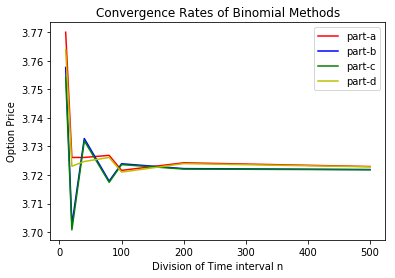

In [15]:
######################### Question 1  ################################

def binomEurCall(So, K, u, d, p, r, T, n):
    call = 0
    for i in range(n):
        call = call + ( f(n)/(f(i)*f(n-i)) )*p**(n-i)*(1-p)**i*max(So*u**(n-i)*d**i - K, 0)   ##f is factorial imported above
    return exp(-r*T)*call


T = 0.5
r = .05
sigma = .24
So = 32
K = 30
N = np.array([10, 20, 40, 80, 100, 200, 500])
    
       
## part a
callPrices = np.array([])
for n in np.nditer(N):
    c = 0.5*(exp(-r*T/n) + exp( (r+sigma**2)*(T/n) ))
    d = c - sqrt(c**2-1)
    u = 1/d
    p = (exp(r*T/n) - d)/(u-d)
    callPrices = np.append(callPrices, binomEurCall(So, K, u, d, p, r, T, n))
plt.plot(N, callPrices, 'r', label='part-a')



## part b
callPrices = np.array([])
for n in np.nditer(N):
    u = exp(r*T/n)*(1+sqrt(exp(sigma**2*(T/n))-1))
    d = exp(r*T/n)*(1-sqrt(exp(sigma**2*(T/n))-1))
    p = 0.5
    callPrices = np.append(callPrices, binomEurCall(So, K, u, d, p, r, T, n))
plt.plot(N, callPrices, 'b', label='part-b')
   
 ## part c
callPrices = np.array([])
for n in np.nditer(N):
    u = exp( (r-sigma**2/2)*(T/n) + sigma*sqrt(T/n) )
    d = exp( (r-sigma**2/2)*(T/n) - sigma*sqrt(T/n) )
    p = 0.5
    callPrices = np.append(callPrices, binomEurCall(So, K, u, d, p, r, T, n))
plt.plot(N, callPrices, 'g', label='part-c')
 
  ## part d
callPrices = np.array([])
for n in np.nditer(N):
    u = exp(sigma*sqrt(T/n))
    d = exp(-sigma*sqrt(T/n))
    p = 0.5 + 0.5*( (r-sigma**2/2)*sqrt(T/n)/sigma )
    callPrices = np.append(callPrices, binomEurCall(So, K, u, d, p, r, T, n))
plt.plot(N, callPrices, 'y', label='part-d')
plt.title("Convergence Rates of Binomial Methods")
plt.xlabel("Division of Time interval n")
plt.ylabel("Option Price")
plt.legend(loc='upper right')
  


In [16]:
  
############################### Ques 2  ######################################
def binomAmericanCallOptionPrice(So, K, u, d, p, r, T, n):
    stockTree = np.zeros((n+1, n+1))
    for i in range(n+1):
        for j in range(i+1):
            stockTree[i, j] = So * u ** (j) * d**((i)-(j))
    optionTree = np.zeros((stockTree.shape[0], stockTree.shape[1]))
    optionTree[optionTree.shape[0]-1, ] = np.maximum(stockTree[stockTree.shape[0]-1,] - K, 0)
   
    for i in range(stockTree.shape[0]-2, -1, -1):
        for j in range(i+1):
            optionTree[i, j] = max( ((1-p)*optionTree[i+1,j] +p*optionTree[i+1,j+1])/exp(r*T/n), max(stockTree[i, j]- K, 0) )
    return optionTree[0,0]

#data_today = pdr.get_data_yahoo("GOOG", start="2018-02-07", end="2018-02-07")
goog = data_today.iloc[0][4]
r = 0.02
K = round(1.1*goog, -1)
#expiration date Jan-18-2019
today = date(2018, 2, 7)
expiry = date(2019, 1, 18)
T = ((expiry-today).days)/365
#extracting google data from yahoo
#data_history60m = pdr.get_data_yahoo("GOOG", start="2018-02-07", end="2013-02-06")
price60m = pd.read_csv('./GOOG.csv')
adjclose = price60m[['Adj Close']]
dailyRet = adjclose/adjclose.shift(1)-1
dailySD = sqrt(var(dailyRet))

sigma = dailySD[0]*sqrt(252)

   
n=100 #running 10 simulation
c = 0.5*(exp(-r*T/n) + exp( (r+sigma**2)*(T/n) ))
d = c - sqrt(c**2-1)
u = 1/d
p = (exp(r*T/n) - d)/(u-d)
  
googCall = binomAmericanCallOptionPrice(goog, K, u, d, p, r, T, n)
print("estimated call price - Google-20190118 ", googCall, "\n")
    
googCallYahoo = 67.50
    
print("estimated call price - Google-20190118 ", googCallYahoo, "\n")
    
increment = 0.001
while (googCallYahoo-googCall > 0.1):
    sigma = sigma + increment
    c =  0.5*(exp(-r*T/n) + exp( (r+sigma**2)*(T/n) ))
    d = c - sqrt(c**2-1)
    u = 1/d
    p = (exp(r*T/n) - d)/(u-d)
    googCall = binomEurCall(goog, K, u, d, p, r, T, n)
 
print("Volatility which makes estimated call price equal to market price ", sigma) 



estimated call price - Google-20190118  130221.01842851126 

estimated call price - Google-20190118  67.5 

Volatility which makes estimated call price equal to market price  0.2212889210856076


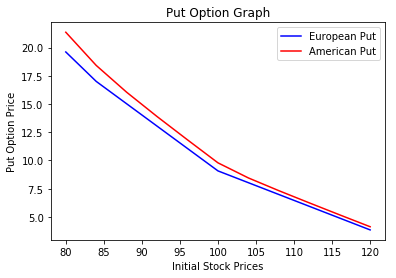

In [19]:
######################## Ques 4 ##############################
def binomEurPut(So, K, u, d, p, r, T, n):
    put = 0
    for i in range(n):
        put = put + ( f(n)/(f(i)*f(n-i)) )*p**(n-i)*(1-p)**i*max(K-So*u**(n-i)*d**i, 0)
    return exp(-r*T)*put

r = 0.05
sigma = .30
K = 100
So = np.arange(80, 120+4, 4)
T = 1
n = 10

c =  0.5*(exp(-r*T/n) + exp( (r+sigma**2)*(T/n) ))
d = c - sqrt(c**2-1)
u = 1/d
p = (exp(r*T/n) - d)/(u-d)

EurPut = np.array([])
for s in np.nditer(So):
    EurPut = np.append(EurPut, binomEurPut(s, K, u, d, p, r, T, n))

plt.plot(So, EurPut, 'b', label='European Put')

#for American Put

def binomAmericanPutOptionPrice(So, K, u, d, p, r, T, n):
    stockTree = np.zeros((n+1, n+1))
    for i in range(n+1):
        for j in range(i+1):
            stockTree[i, j] = So * u ** (j) * d**((i)-(j))
    optionTree = np.zeros((stockTree.shape[0], stockTree.shape[1]))
    optionTree[optionTree.shape[0]-1, ] = np.maximum(K - stockTree[stockTree.shape[0]-1,], 0)
   
    for i in range(stockTree.shape[0]-2, -1, -1):
        for j in range(i+1):
            optionTree[i, j] = max( ((1-p)*optionTree[i+1,j] +p*optionTree[i+1,j+1])/exp(r*T/n), max(K-stockTree[i, j], 0) )
    return optionTree[0,0]
 
AmerPut = np.array([])    
for s in np.nditer(So):
    AmerPut = np.append(AmerPut, binomAmericanPutOptionPrice(s, K, u, d, p, r, T, n))
plt.plot(So, AmerPut, 'r', label='American Put')
plt.xlabel("Initial Stock Prices")
plt.ylabel("Put Option Price")
plt.title("Put Option Graph")
plt.legend(loc='upper right')




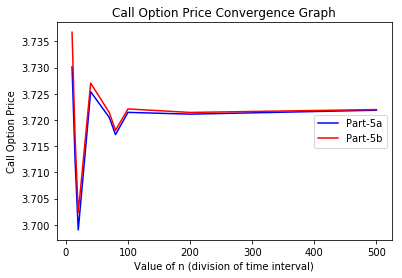

In [20]:
############################Ques 5 #######################################
## 5.a
def trinomEurCall_ud(So, K, u, d, Pu, Pd, Pm, r, T, n):
    stockTree = np.zeros((n+1, 2*n+1))
    for i in range(n+1):
        for j in range(2*i+1):
            stockTree[i, j] = So * u ** max(j-i, 0) * d**max((i-j, 0))
    optionTree = np.zeros((stockTree.shape[0], stockTree.shape[1]))
    optionTree[optionTree.shape[0]-1, ] = np.maximum(stockTree[stockTree.shape[0]-1,]-K, 0)
   
    for i in range(stockTree.shape[0]-2, -1, -1):
        for j in range(2*i+1):
            optionTree[i, j] = (Pd*optionTree[i+1,j] + Pm*optionTree[i+1,j+1] + Pu*optionTree[i+1,j+2] )/exp(r*T/n)
    return optionTree[0,0]

T = 0.5
r = 0.05
sigma = 0.24
So = 32
K = 30
N = np.array([10, 15, 20, 40, 70, 80, 100, 200, 500])

call5a = np.array([])
for n in np.nditer(N):
    d = exp(-sigma*sqrt(3*T/n))
    u = 1/d
    Pd = ( r*(T/n)*(1-u) + (r*T/n)**2 + sigma**2*(T/n) )/( (u-d)*(1-d) )
    Pu = ( r*(T/n)*(1-d) + (r*T/n)**2 + sigma**2*(T/n) )/( (u-d)*(u-1) )
    Pm = 1-Pu-Pd
    call5a = np.append(call5a, trinomEurCall_ud(So, K, u, d, Pu, Pd, Pm, r, T, n))

plt.plot(N, call5a, 'b', label='Part-5a')

## 5.b

def trinomEurCall_deltaX(So, K, x, Pu, Pd, Pm, r, T, n):
    lnStockTree = np.zeros((n+1, 2*n+1))
    for i in range(n+1):
        for j in range(2*i+1):
            lnStockTree[i, j] = log(So) - (i-j)*x
    stockTree = np.where(lnStockTree>0, exp(lnStockTree), 0)
    optionTree = np.zeros((stockTree.shape[0], stockTree.shape[1]))
    optionTree[optionTree.shape[0]-1, ] = np.maximum(stockTree[lnStockTree.shape[0]-1,]-K, 0)
   
    for i in range(lnStockTree.shape[0]-2, -1, -1):
        for j in range(2*i+1):
            optionTree[i, j] = ( Pd*optionTree[i+1,j] + Pm*optionTree[i+1,j+1] + Pu*optionTree[i+1,j+2] )/exp(r*T/n) 
    return optionTree[0,0]


call5b = np.array([])
for n in np.nditer(N):
    x = sigma*sqrt(3*T/n)
    Pd = 0.5*(   ( sigma**2*(T/n)+(r-sigma**2/2)**2*(T/n)**2)/(x**2) -  (r-sigma**2/2)*(T/n)/x )
    Pu = 0.5*(   ( sigma**2*(T/n)+(r-sigma**2/2)**2*(T/n)**2)/(x**2) +  (r-sigma**2/2)*(T/n)/x )
    Pm = 1-Pu-Pd
    call5b = np.append(call5b, trinomEurCall_deltaX(So, K, x, Pu, Pd, Pm, r, T, n))

plt.plot(N, call5b, 'r', label='Part-5b')

plt.xlabel("Value of n (division of time interval)")
plt.ylabel("Call Option Price")
plt.title("Call Option Price Convergence Graph")
plt.legend(loc='center right')



In [21]:


######################################## Ques 6 ###################################

#Generates Halton Sequence 
# Code help taken from Class notes matlab code and implemented in Python
def genHalton(size, base):
    seq = np.zeros(size)
    bits = 1+np.ceil(log(size)/log(base))
    VetBase = pow(base, -np.arange(bits+1))
    WorkVet = np.zeros(int(bits+1))
    for i in range(size):
        j = 1
        ok = 0
        while ok == 0:
            WorkVet[j] = WorkVet[j]+1
            if(WorkVet[j] < base):
                ok = 1
            else:
                WorkVet[j] = 0
                j = j+1
        
        seq[i] = sum(WorkVet*VetBase)
    return seq

# Generates N(0,1) using Box-Muller method
# @param n = number of standard normal random numbers
# @param seed
# @return numpy array of 'n' N(0,1) numbers
def genStandardNorm(n, b1, b2, seed=100):
    rnorm = np.array([])
    H1 = genHalton(n//2, b1)
    H2 = genHalton(n//2, b2)
    z1 = sqrt(-2*log(H1))*cos(2*pi*H2)
    z2 = sqrt(-2*log(H1))*sin(2*pi*H2)
    rnorm = np.append(rnorm, z1) 
    rnorm = np.append(rnorm, z2)
    return rnorm

def ques6_EurCallPrice(So, K, sigma, r, T, N, b1, b2):
    z = genStandardNorm(N, b1, b2, 100)
    St = So*exp( (r-sigma**2/2)*T + sigma*sqrt(T)*z )
    payoff = St-K
    payoff = np.where(payoff>0, payoff, 0)
    return exp(-r*T)*mean(payoff)

ques6_EurCallPrice(100, 100, 0.25, 0.05, 1, 20, 2, 5)



12.880859699190266